# HW10 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

### Author: Avikal Somvanshi

## Import libraries and packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import seaborn
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors
from IPython.display import Image

## Working with Shape File

### Loading Census Tract Shape File¶

In [2]:
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [3]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

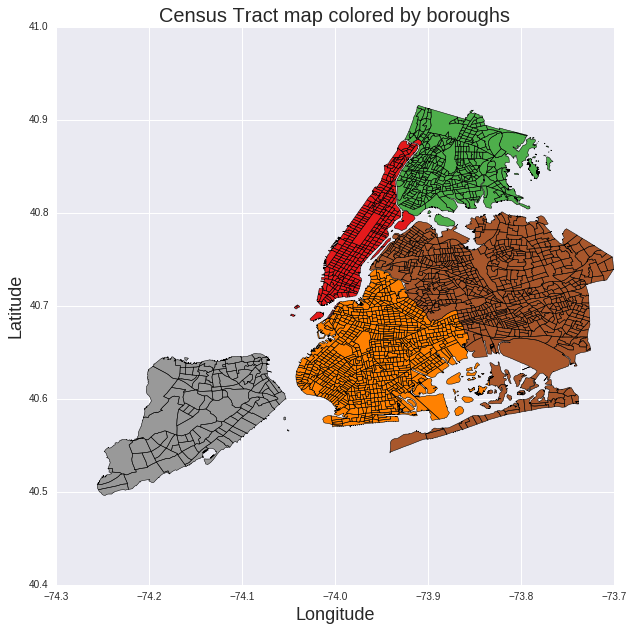

In [4]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
ax.set_title("Census Tract map colored by boroughs", fontsize=20)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

#### Figure1: Census tract map of New York City colored by boroughs 

### Map NYC Population density

#### Load Census Data for 2010

In [5]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
ct_data.index=ct_data.BoroCT2010.astype(str)
ct_data.head()

BoroCT2010             Geo_NAME  \
BoroCT2010                                    
5000900        5000900       Census Tract 9   
5012500        5012500     Census Tract 125   
5013301        5013301  Census Tract 133.01   
5019700        5019700     Census Tract 197   
5002002        5002002   Census Tract 20.02   

                                                 Geo_QName     Geo_FIPS  \
BoroCT2010                                                                
5000900          Census Tract 9, Richmond County, New York  36085000900   
5012500        Census Tract 125, Richmond County, New York  36085012500   
5013301     Census Tract 133.01, Richmond County, New York  36085013301   
5019700        Census Tract 197, Richmond County, New York  36085019700   
5002002      Census Tract 20.02, Richmond County, New York  36085002002   

            Geo_SUMLEV  Geo_GEOCOMP  Geo_STATE  Geo_COUNTY  Geo_COUNTYSC  \
BoroCT2010                                                                 
5000900            140            0         36          85            19   
5012500            140            0         36          85            19   
5013301            140            0         36          85            19   
5019700            140            0         36          85            19   
5002002            140            0         36          85            19   

            Geo_COUSUB     ...       SE_T017_017  SE_T017_018  SE_T017_019  \
BoroCT2010                 ...                                               
5000900            NaN     ...                32           23           13   
5012500            NaN     ...                50           50           28   
5013301            NaN     ...                 0           11            6   
5019700            NaN     ...                48           56           36   
5002002            NaN     ...                73          126           53   

            SE_T017_020  SE_T017_021  SE_T017_022  SE_T017_023  SE_T017_024  \
BoroCT2010                                                                    
5000900              12           10           12           11            7   
5012500              33           36           32           42           20   
5013301               3           15            4            4            4   
5019700              50           54           32           44           36   
5002002              73          114           83           63           63   

            SE_T017A001  SE_T017A002  
BoroCT2010                            
5000900             746           50  
5012500            1522           89  
5013301             303           24  
5019700            1672           97  
5002002            2562          104  

[5 rows x 257 columns]

#### Add popuation density to CT shapefile

In [6]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

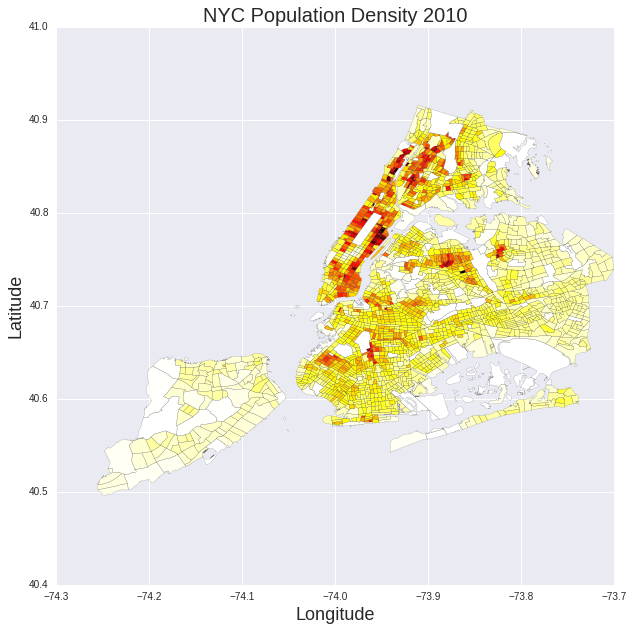

In [7]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_pop.plot(column='SE_T002_002', cmap='hot_r', alpha=1, linewidth=0.1, ax=ax)
ax.set_title("NYC Population Density 2010", fontsize=20)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

#### Figure2: Heat-map og population density of NYC by census tracts

## Explore CitiBike data

### Load CitiBike data

In [8]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

1000  1001   1002  1003  1004  1005  1006  1007  1008  1009  ...   \
starttime                                                                ...    
2013-07-31  2343  3914   6979  2750  4914  2229  2183  3139  3622  2368  ...    
2013-08-31  2696  4429   9020  3433  6645  2768  2761  3422  4271  2910  ...    
2013-09-30  2878  5258   9814  3739  7837  3206  2747  3590  4618  2885  ...    
2013-10-31  2920  4409  10456  3520  8928  3237  2530  3909  4169  2542  ...    
2013-11-30  1883  2731   6384  2446  5201  2085  1415  2727  3146  1539  ...    

            1533  1534  1535  1536  1537  1538  1539  1540  1541  1542  
starttime                                                               
2013-07-31     0     0     0     0     0     0     0     0     0     0  
2013-08-31     0     0     0     0     0     0     0     0     0     0  
2013-09-30     0     0     0     0     0     0     0     0     0     0  
2013-10-31     0     0     0     0     0     0     0     0     0     0  
2013-11-30     0     0     0     0     0     0     0     0     0     0  

[5 rows x 543 columns]

In [9]:
#extracting summer (June-September) months
summer = df_bike_monthly.iloc[:3]
for i in range (1,4):
    summer = summer.append(df_bike_monthly.iloc[(12 * i) - 1:(12 * i) + 3])
    
summer.head()

1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...   \
starttime                                                               ...    
2013-07-31  2343  3914  6979  2750  4914  2229  2183  3139  3622  2368  ...    
2013-08-31  2696  4429  9020  3433  6645  2768  2761  3422  4271  2910  ...    
2013-09-30  2878  5258  9814  3739  7837  3206  2747  3590  4618  2885  ...    
2014-06-30  2048  3306  9626  3515  7255  2942  1917  3702  3694  2422  ...    
2014-07-31  2252  3216  9825  3509  7014  3224  2195  3732  4042  2268  ...    

            1533  1534  1535  1536  1537  1538  1539  1540  1541  1542  
starttime                                                               
2013-07-31     0     0     0     0     0     0     0     0     0     0  
2013-08-31     0     0     0     0     0     0     0     0     0     0  
2013-09-30     0     0     0     0     0     0     0     0     0     0  
2014-06-30     0     0     0     0     0     0     0     0     0     0  
2014-07-31     0     0     0     0     0     0     0     0     0     0  

[5 rows x 543 columns]

In [10]:
#extracting winter (December-March) months
winter = df_bike_monthly.iloc[5:9]
for i in range (1,4):
    winter = winter.append(df_bike_monthly.iloc[(12 * i) - 7:(12 * i) - 3])
    
winter.head()

1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...   \
starttime                                                               ...    
2013-12-31  1299  1650  4081  1686  3046  1575   830  1890  2048  1009  ...    
2014-01-31   956  1337  3178  1251  1920  1130   477  1412  1082   681  ...    
2014-02-28   650   960  2920   676  1808   933   508  1045   963   530  ...    
2014-03-31   804  1559  5102  1441  2643  1477   849  2004  2105   880  ...    
2013-12-31  1299  1650  4081  1686  3046  1575   830  1890  2048  1009  ...    

            1533  1534  1535  1536  1537  1538  1539  1540  1541  1542  
starttime                                                               
2013-12-31     0     0     0     0     0     0     0     0     0     0  
2014-01-31     0     0     0     0     0     0     0     0     0     0  
2014-02-28     0     0     0     0     0     0     0     0     0     0  
2014-03-31     0     0     0     0     0     0     0     0     0     0  
2013-12-31     0     0     0     0     0     0     0     0     0     0  

[5 rows x 543 columns]

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [11]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

lat        lon
1000  40.753231 -73.970325
1001  40.749718 -74.002950
1002  40.730287 -73.990765
1003  40.718939 -73.992663
1004  40.734927 -73.992005

### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [12]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

lat        lon                         lonlat  \
1000  40.753231 -73.970325    (-73.97032517, 40.75323098)   
1001  40.749718 -74.002950  (-74.002950346, 40.749717753)   
1002  40.730287 -73.990765     (-73.9907647, 40.73028666)   
1003  40.718939 -73.992663    (-73.99266288, 40.71893904)   
1004  40.734927 -73.992005    (-73.99200509, 40.73492695)   

                                     geometry  
1000         POINT (-73.97032517 40.75323098)  
1001  POINT (-74.00295034600001 40.749717753)  
1002          POINT (-73.9907647 40.73028666)  
1003         POINT (-73.99266288 40.71893904)  
1004   POINT (-73.99200509000001 40.73492695)

### Intersect the two geometries

In [13]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [14]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

## Time Series Analysis for complete data

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


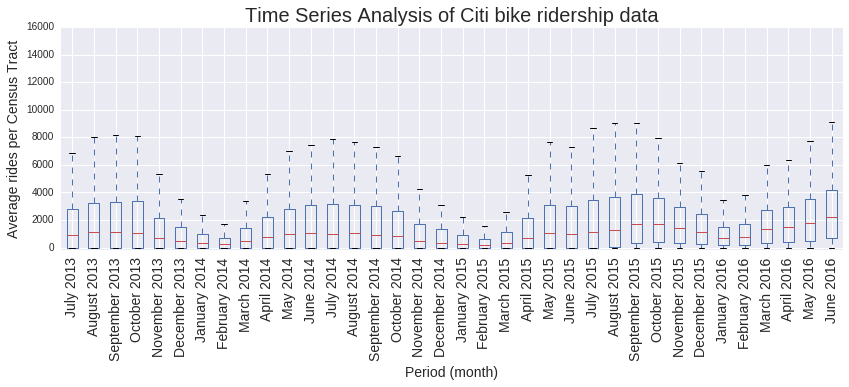

In [15]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
ax.set_title("Time Series Analysis of Citi bike ridership data", fontsize=20)
ax.set_ylabel('Average rides per Census Tract', fontsize=14)
ax.set_xlabel("Period (month)", fontsize=14)

#### Figure3: The time series analysis shows that there is a seasonal tread in the bike ridership.

## Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


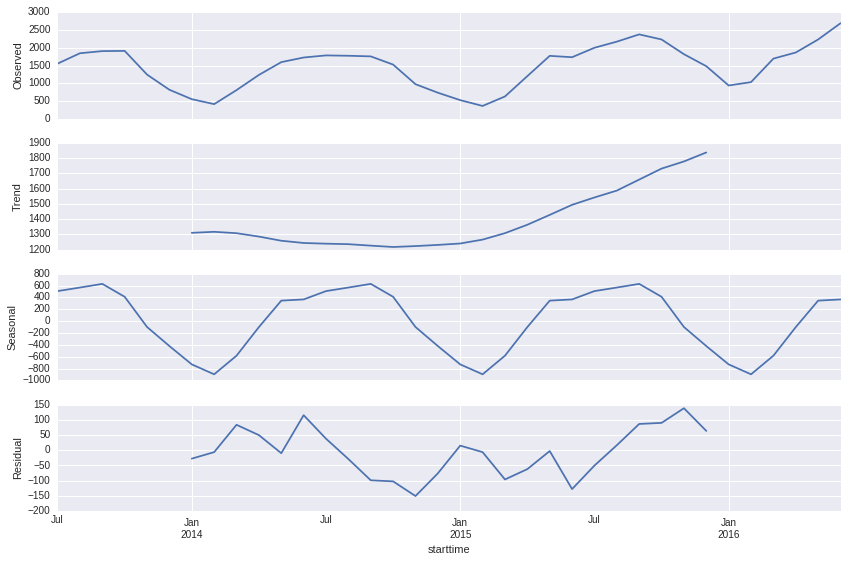

In [16]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

#### Figure4: The seasonal decompostion confirms that there is a seasonal tread in the bike ridership.

## Time Series Analysis of Summer data

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


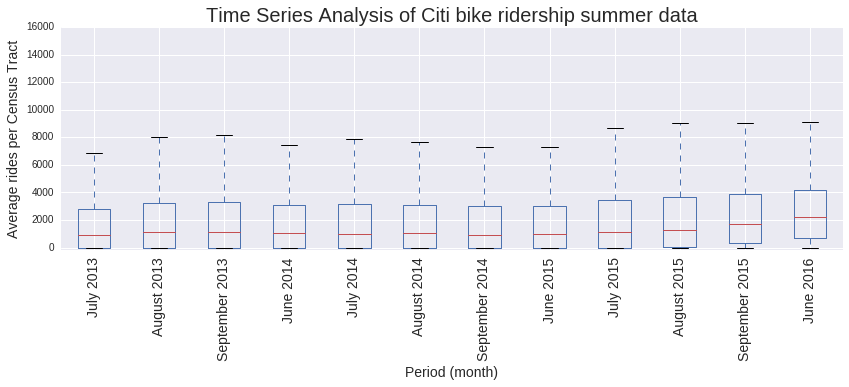

In [17]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
summer1 = summer.copy()
summer1.index=summer1.index.strftime("%B %Y")
summer1.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
ax.set_title("Time Series Analysis of Citi bike ridership summer data", fontsize=20)
ax.set_ylabel('Average rides per Census Tract', fontsize=14)
ax.set_xlabel("Period (month)", fontsize=14)

#### Figure4: The average rides in summer months are approximately same.

### Add Summer Monthly rides to the station GeoDataFrame with CT code

In [18]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['SummerMonthlyAve']= summer.mean()

In [19]:
station_id.head()

lat        lon                         lonlat  \
1000  40.753231 -73.970325    (-73.97032517, 40.75323098)   
1001  40.749718 -74.002950  (-74.002950346, 40.749717753)   
1002  40.730287 -73.990765     (-73.9907647, 40.73028666)   
1003  40.718939 -73.992663    (-73.99266288, 40.71893904)   
1004  40.734927 -73.992005    (-73.99200509, 40.73492695)   

                                     geometry BoroCT2010  SummerMonthlyAve  
1000         POINT (-73.97032517 40.75323098)    1009000       2558.000000  
1001  POINT (-74.00295034600001 40.749717753)    1009900       3830.500000  
1002          POINT (-73.9907647 40.73028666)    1005700       9903.083333  
1003         POINT (-73.99266288 40.71893904)    1001800       3732.833333  
1004   POINT (-73.99200509000001 40.73492695)    1006100       6895.750000

### Add the summer monthly average rides to the CT shapefile 

In [20]:
temp=station_id[['SummerMonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_SummerMonthlyAve=ct_shape.join(temp)
ct_shape_SummerMonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


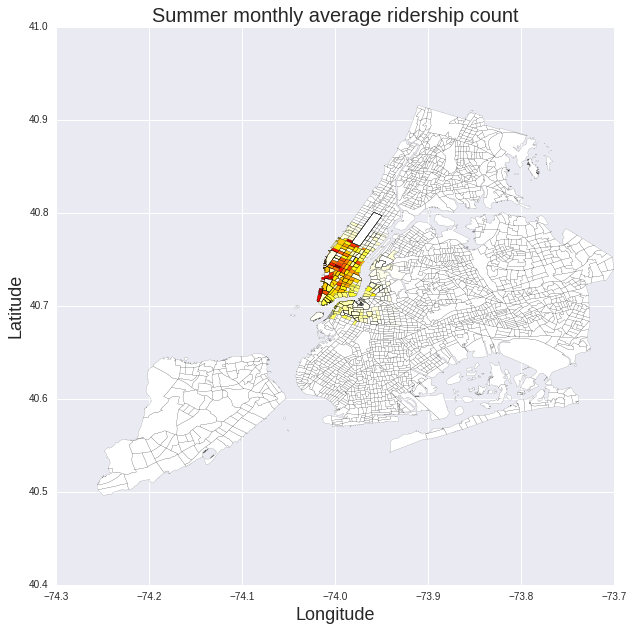

In [21]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_SummerMonthlyAve.plot(column='SummerMonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
ax.set_title("Summer monthly average ridership count", fontsize=20)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

#### Figure5: Most of the ridership is concentrated in Manhattan

### Removing the CTs that are out of zoom boundries

In [22]:
ct_shape_SummerMonthlyAve_Zoom = (ct_shape_SummerMonthlyAve[ct_shape_SummerMonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [23]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.SummerMonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the Summer monthly rides 

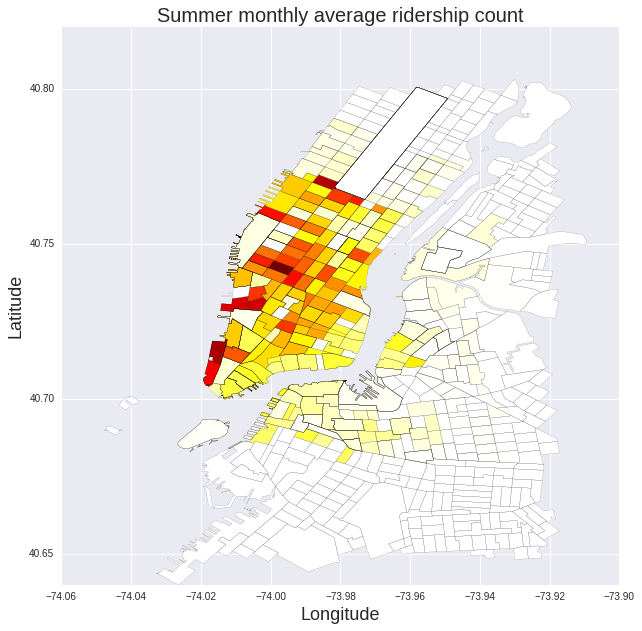

In [24]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_SummerMonthlyAve_Zoom.plot(column='SummerMonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
ax.set_title("Summer monthly average ridership count", fontsize=20)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

#### Figure6: Most bike rides are observed in Manhattan

### Export Shapefile CTs in the CitiBike Zone

In [25]:
path='Output/ct_shape_SummerMonthlyAve_Zoom.shp'
ct_shape_SummerMonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis of summer data

### Spatial Weights
Contiguity: Queen Weights

In [26]:
qW_CTsummer=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [27]:
qW_CTsummer[5]

{6: 1.0, 7: 1.0, 409: 1.0, 410: 1.0, 456: 1.0, 459: 1.0}

In [28]:
qW_CTsummer.cardinalities[5]

6

#### Matrix of Weights

In [29]:
Wmatrix_summer, idsummer = qW_CTsummer.full()

In [30]:
Wmatrix_summer

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [31]:
qW_CTsummer.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [32]:
SummerMonthlyRide=ct_shape_SummerMonthlyAve_Zoom.SummerMonthlyAve
SummerMonthlyRideLag=ps.lag_spatial(qW_CTsummer, SummerMonthlyRide)

#### Create Quantiles for maping

In [33]:
SummerMonthlyRideLagQ10 = ps.Quantiles(SummerMonthlyRideLag, k=10)
SummerMonthlyRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    7.333                 2
   7.333 < x[i] <=  125.969                78
 125.969 < x[i] <=  256.250                80
 256.250 < x[i] <=  629.283                81
 629.283 < x[i] <=  968.988                78
 968.988 < x[i] <= 2141.150                79
2141.150 < x[i] <= 3116.268                80
3116.268 < x[i] <= 3599.888                79
3599.888 < x[i] <= 5503.042                80

#### Map the summer monthly rides lag

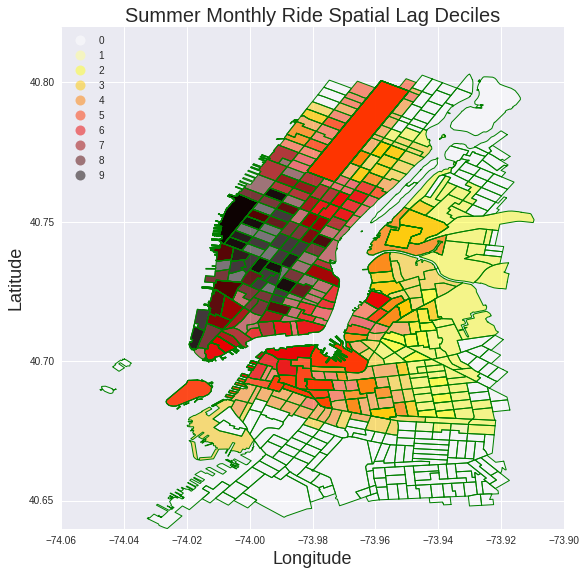

In [34]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_SummerMonthlyAve_Zoom.assign(cl=SummerMonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=1, ax=ax, 
        edgecolor='green', legend=True)
ax.set_title("Summer Monthly Ride Spatial Lag Deciles", fontsize=20)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

#### Figure7: The census tract in Manhattan have highest spatial lag.

## Global  Spatial Autocorrelation

In [35]:
b,a = np.polyfit(SummerMonthlyRide, SummerMonthlyRideLag, 1)
b,a 

(0.6438931431258913, 473.57758989515457)

### Moran Scatterplot

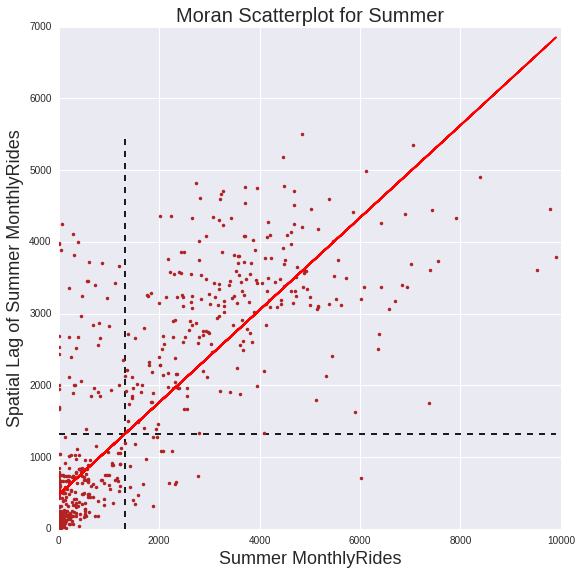

In [36]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SummerMonthlyRide, SummerMonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerMonthlyRide.mean(), SummerMonthlyRideLag.min(), SummerMonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerMonthlyRideLag.mean(), SummerMonthlyRide.min(), SummerMonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerMonthlyRide, a + b*SummerMonthlyRide, 'r')
plt.title('Moran Scatterplot for Summer', fontsize=20)
plt.ylabel('Spatial Lag of Summer MonthlyRides', fontsize=18)
plt.xlabel('Summer MonthlyRides', fontsize=18)

#### Figure8: The Moran Scatterplot for summer riderships in NYC.

### Moran's I

In [37]:
I_SummerMonthlyRide = ps.Moran(SummerMonthlyRide, qW_CTsummer)

In [38]:
I_SummerMonthlyRide.I, I_SummerMonthlyRide.p_sim

(0.64406949906809741, 0.001)

#### Thus, the $I$ statistic is $0.644$ for this data which means that the spatial distribution is not random and has segrigated into two distinct clusters. Further it has a very small $p$ value. 

In [39]:
I_SummerMonthlyRide.sim[0:10]

array([ 0.02820617,  0.02002193,  0.0116295 , -0.00563078,  0.00214469,
       -0.02120642, -0.01999321, -0.00535852,  0.00183796,  0.0163683 ])

### KDEplot of all of the simulated points


(-0.7, 0.7)

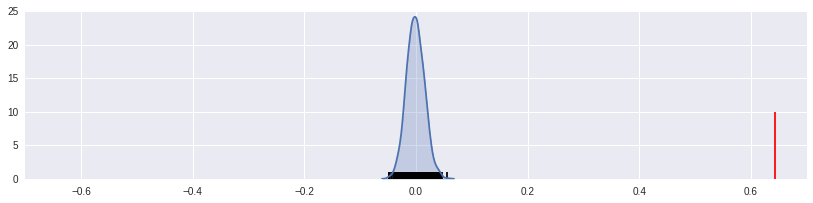

In [40]:
plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_SummerMonthlyRide.sim, shade=True)
plt.vlines(I_SummerMonthlyRide.sim, 0, 1)
plt.vlines(I_SummerMonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

#### Figure8: The vertical line shows the observed value

(-0.7, 0.7)

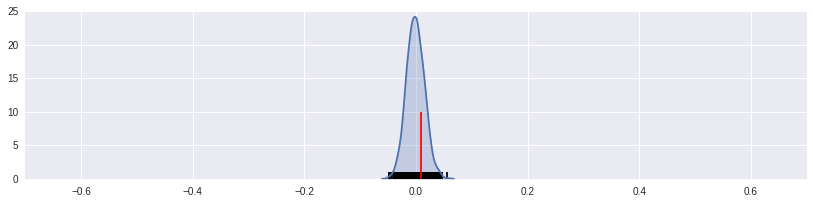

In [41]:
sns.kdeplot(I_SummerMonthlyRide.sim, shade=True)
plt.vlines(I_SummerMonthlyRide.sim, 0, 1)
plt.vlines(I_SummerMonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

#### Figure8: In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

## Local  Spatial Autocorrelation

In [42]:
LMo_SummerMonthlyRide = ps.Moran_Local(SummerMonthlyRide, qW_CTsummer,permutations=999)

In [43]:
LMo_SummerMonthlyRide.Is[0:5], LMo_SummerMonthlyRide.p_sim[0:5]

(array([-0.        , -0.23689404,  0.01179723,  0.00235718,  0.0247348 ]),
 array([ 0.001,  0.192,  0.33 ,  0.355,  0.405]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [44]:
sigs_s = SummerMonthlyRide[LMo_SummerMonthlyRide.p_sim <= .001]
W_sigs_s = SummerMonthlyRideLag[LMo_SummerMonthlyRide.p_sim <= .001]
insigs_s = SummerMonthlyRide[LMo_SummerMonthlyRide.p_sim > .001]
W_insigs_s = SummerMonthlyRideLag[LMo_SummerMonthlyRide.p_sim > .001]

### Plot Signficant LISA

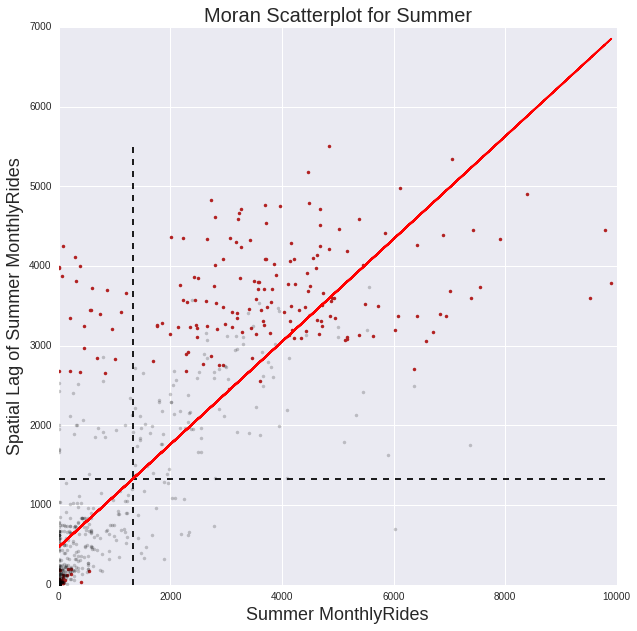

In [81]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot(sigs_s, W_sigs_s, '.', color='firebrick')
plt.plot(insigs_s, W_insigs_s, '.k', alpha=.2)
#plt.text(s='$I = %.3f$' % I_SummerMonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerMonthlyRide.mean(), SummerMonthlyRideLag.min(), SummerMonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerMonthlyRideLag.mean(), SummerMonthlyRide.min(), SummerMonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerMonthlyRide, a + b*SummerMonthlyRide, 'r')

plt.title('Moran Scatterplot for Summer', fontsize=20)
plt.ylabel('Spatial Lag of Summer MonthlyRides', fontsize=18)
plt.xlabel('Summer MonthlyRides', fontsize=18)

### Hot and Cold spots for summer 

In [46]:
sig_s = LMo_SummerMonthlyRide.p_sim < 0.01
hotspots_s = LMo_SummerMonthlyRide.q==1 * sig_s
coldspots_s = LMo_SummerMonthlyRide.q==3 * sig_s
print "Number of Summer Hotspots:", hotspots_s.sum()
print "Number of Summer Coldspots:", coldspots_s.sum()

Number of Summer Hotspots: 188
Number of Summer Coldspots: 237


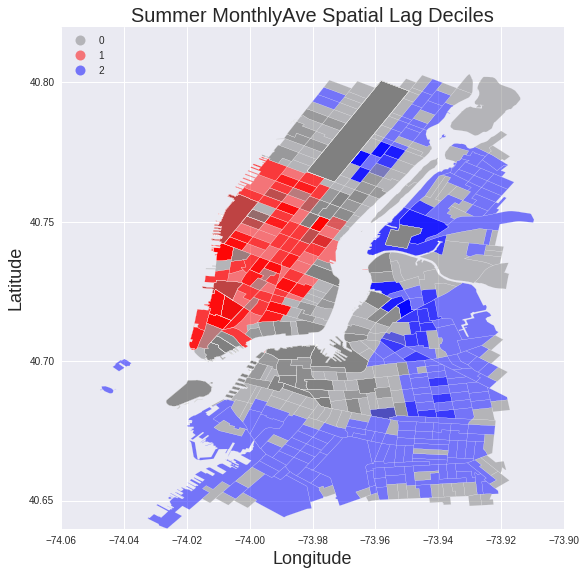

In [47]:
hcmap_s = colors.ListedColormap(['grey','red','blue'])
hotcold_s = hotspots_s*1 + coldspots_s*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_SummerMonthlyAve_Zoom.assign(cl=hotcold_s).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_s, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
plt.title('Summer MonthlyAve Spatial Lag Deciles', fontsize=20)
plt.ylabel('Latitude', fontsize=18)
plt.xlabel('Longitude', fontsize=18)

#### Figure9: There are 190 ridership hotspots mostly located in lower Manhattan while the 241 coldspots are spread across middle Manhattan, Brooklyn and Queens

## Analysis of Winter Months

## Time Series Analysis of Summer data

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


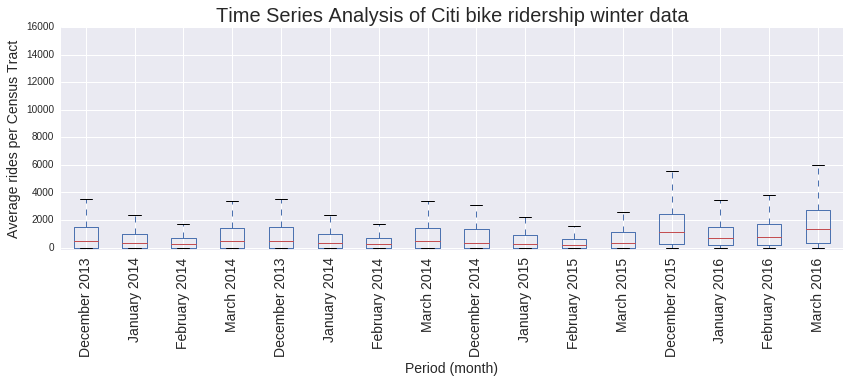

In [48]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
winter1 = winter.copy()
winter1.index = winter1.index.strftime("%B %Y")
winter1.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
ax.set_title("Time Series Analysis of Citi bike ridership winter data", fontsize=20)
ax.set_ylabel('Average rides per Census Tract', fontsize=14)
ax.set_xlabel("Period (month)", fontsize=14)

#### Figure10: The average rides in winter months have increased over years.

### Add Winter Monthly rides to the station GeoDataFrame with CT code

In [49]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['WinterMonthlyAve']= winter.mean()

In [50]:
station_id.head()

lat        lon                         lonlat  \
1000  40.753231 -73.970325    (-73.97032517, 40.75323098)   
1001  40.749718 -74.002950  (-74.002950346, 40.749717753)   
1002  40.730287 -73.990765     (-73.9907647, 40.73028666)   
1003  40.718939 -73.992663    (-73.99266288, 40.71893904)   
1004  40.734927 -73.992005    (-73.99200509, 40.73492695)   

                                     geometry BoroCT2010  SummerMonthlyAve  \
1000         POINT (-73.97032517 40.75323098)    1009000       2558.000000   
1001  POINT (-74.00295034600001 40.749717753)    1009900       3830.500000   
1002          POINT (-73.9907647 40.73028666)    1005700       9903.083333   
1003         POINT (-73.99266288 40.71893904)    1001800       3732.833333   
1004   POINT (-73.99200509000001 40.73492695)    1006100       6895.750000   

      WinterMonthlyAve  
1000         1054.5000  
1001         1351.1875  
1002         4263.8125  
1003         1537.1875  
1004         2546.0000

### Add the summer monthly average rides to the CT shapefile 

In [51]:
tempw=station_id[['WinterMonthlyAve']]
tempw['station_id']=station_id.index
tempw.index=station_id['BoroCT2010']
ct_shape_WinterMonthlyAve=ct_shape.join(tempw)
ct_shape_WinterMonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


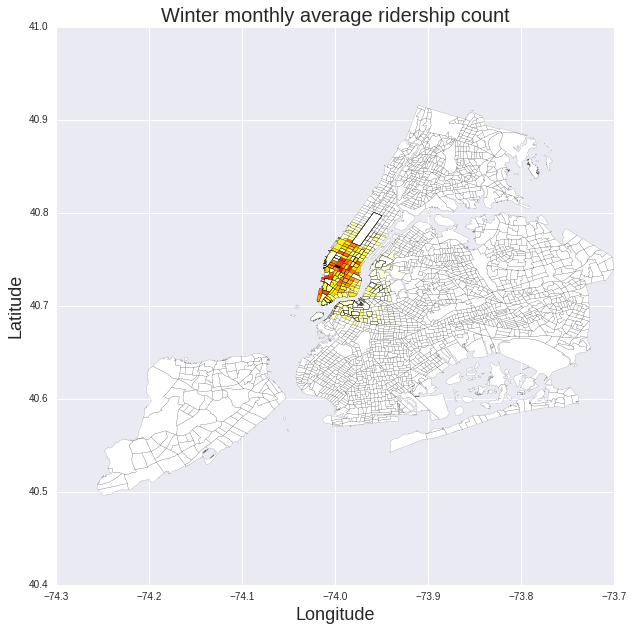

In [52]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_WinterMonthlyAve.plot(column='WinterMonthlyAve', cmap='hot_r', alpha=1, linewidth=0.1, ax=ax)
ax.set_title("Winter monthly average ridership count", fontsize=20)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

#### Figure11: Most of the ridership is concentrated in Manhattan

### Removing the CTs that are out of zoom boundries

In [53]:
ct_shape_WinterMonthlyAve_Zoom = (ct_shape_WinterMonthlyAve[ct_shape_WinterMonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [54]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(tempw.WinterMonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the Winter monthly rides 

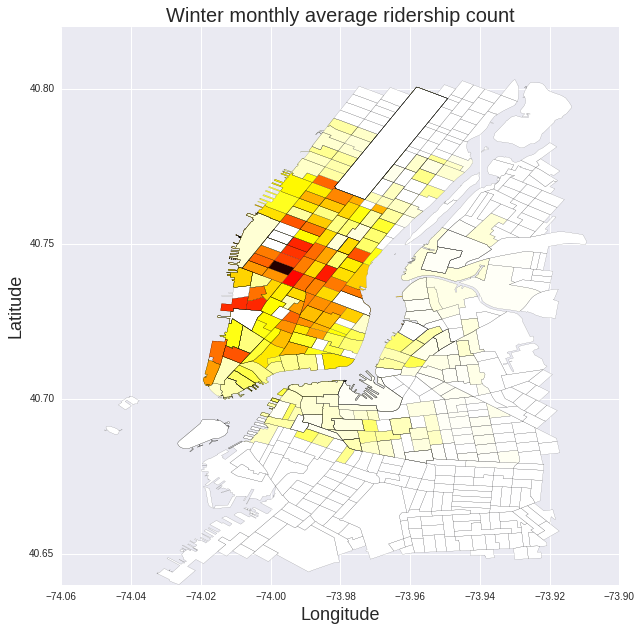

In [55]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_WinterMonthlyAve_Zoom.plot(column='WinterMonthlyAve', cmap='hot_r', alpha=1, linewidth=0.1, ax=ax)
ax.set_title("Winter monthly average ridership count", fontsize=20)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

#### Figure12: Most bike rides are observed in Manhattan

### Export Shapefile CTs in the CitiBike Zone

In [56]:
path='Output/ct_shape_WinterMonthlyAve_Zoom.shp'
ct_shape_WinterMonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis of winter data

### Spatial Weights
Contiguity: Queen Weights

In [57]:
qW_CTwinter=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [58]:
qW_CTwinter[5]

{6: 1.0, 7: 1.0, 409: 1.0, 410: 1.0, 456: 1.0, 459: 1.0}

In [59]:
qW_CTwinter.cardinalities[5]

6

#### Matrix of Weights

In [60]:
Wmatrix_w, idwinter = qW_CTwinter.full()

In [61]:
Wmatrix_w

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [62]:
qW_CTwinter.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [63]:
WinterMonthlyRide=ct_shape_WinterMonthlyAve_Zoom.WinterMonthlyAve
WinterMonthlyRideLag=ps.lag_spatial(qW_CTwinter, WinterMonthlyRide)

#### Create Quantiles for maping

In [64]:
WinterMonthlyRideLagQ10 = ps.Quantiles(WinterMonthlyRideLag, k=10)
WinterMonthlyRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=    3.446                 2
   3.446 < x[i] <=   61.379                78
  61.379 < x[i] <=  155.196                80
 155.196 < x[i] <=  255.046                79
 255.046 < x[i] <=  367.326                80
 367.326 < x[i] <=  898.656                79
 898.656 < x[i] <= 1205.866                80
1205.866 < x[i] <= 1467.853                79
1467.853 < x[i] <= 2376.509                80

#### Map the winter monthly rides lag

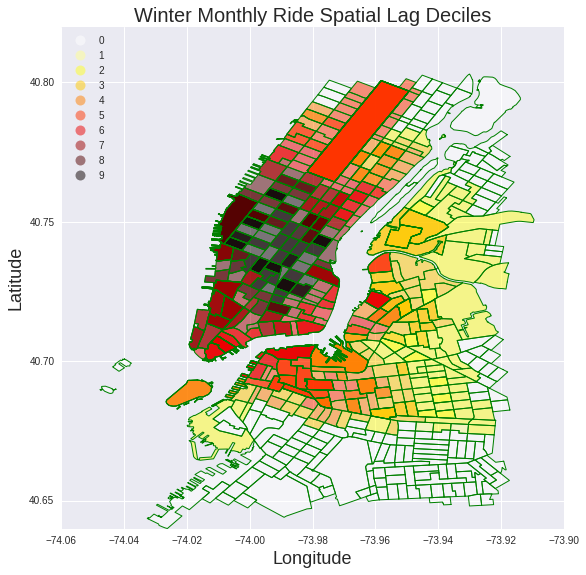

In [65]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterMonthlyAve_Zoom.assign(cl=WinterMonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=1, ax=ax, 
        edgecolor='green', legend=True)
ax.set_title("Winter Monthly Ride Spatial Lag Deciles", fontsize=20)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

#### Figure13: The census tract in Manhattan have highest spatial lag.

## Global  Spatial Autocorrelation

In [66]:
b1,a1 = np.polyfit(WinterMonthlyRide, WinterMonthlyRideLag, 1)
b1,a1 

(0.66794043734093311, 179.12655768368859)

### Moran Scatterplot

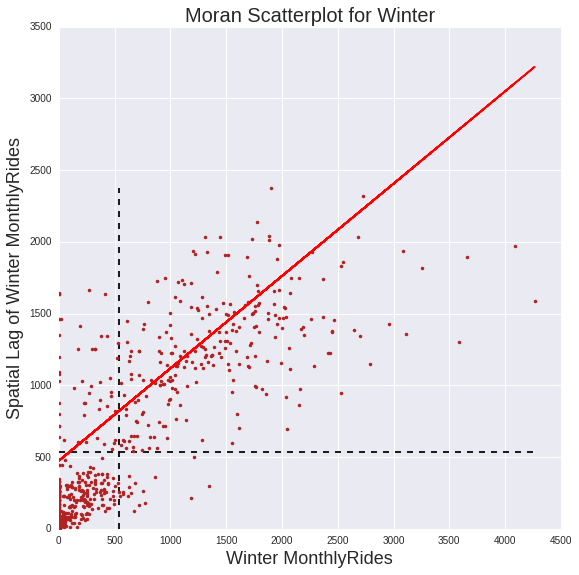

In [67]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterMonthlyRide, WinterMonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterMonthlyRide.mean(), WinterMonthlyRideLag.min(), WinterMonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterMonthlyRideLag.mean(), WinterMonthlyRide.min(), WinterMonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterMonthlyRide, a + b*WinterMonthlyRide, 'r')
plt.title('Moran Scatterplot for Winter', fontsize=20)
plt.ylabel('Spatial Lag of Winter MonthlyRides', fontsize=18)
plt.xlabel('Winter MonthlyRides', fontsize=18)

#### Figure14: The Moran Scatterplot for winter riderships in NYC.

### Moran's I

In [68]:
I_WinterMonthlyRide = ps.Moran(WinterMonthlyRide, qW_CTwinter)

In [69]:
I_WinterMonthlyRide.I, I_WinterMonthlyRide.p_sim

(0.66811761507898915, 0.001)

#### Thus, the $I$ statistic is $0.668$ for this data which means that the spatial distribution is not random and has segrigated into two distinct clusters. Further it has a very small $p$ value. 

In [70]:
I_WinterMonthlyRide.sim[0:10]

array([ 0.00049387, -0.01772974, -0.00433065,  0.00293219,  0.00913765,
       -0.00154259, -0.00968733,  0.008823  , -0.01264641, -0.01344563])

### KDEplot of all of the simulated points


(-0.7, 0.7)

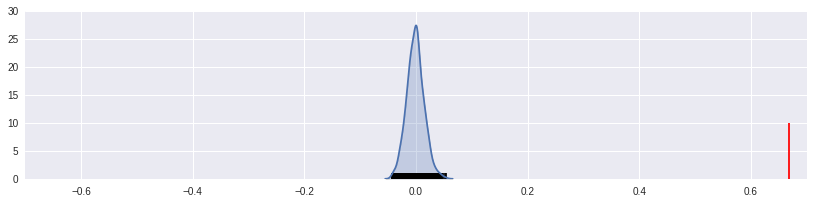

In [71]:
plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_WinterMonthlyRide.sim, shade=True)
plt.vlines(I_WinterMonthlyRide.sim, 0, 1)
plt.vlines(I_WinterMonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

#### Figure15: The vertical line shows the observed value

(-0.7, 0.7)

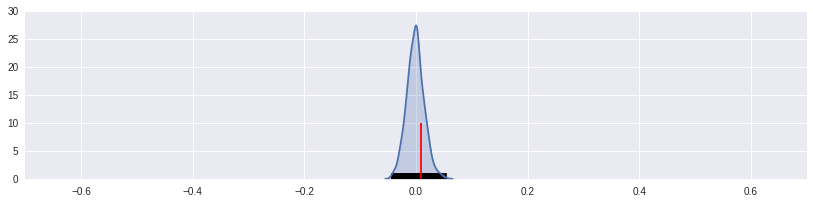

In [72]:
sns.kdeplot(I_WinterMonthlyRide.sim, shade=True)
plt.vlines(I_WinterMonthlyRide.sim, 0, 1)
plt.vlines(I_WinterMonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

#### Figure16: In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

## Local  Spatial Autocorrelation

In [73]:
LMo_WinterMonthlyRide = ps.Moran_Local(WinterMonthlyRide, qW_CTwinter,permutations=999)

In [74]:
LMo_WinterMonthlyRide.Is[0:5], LMo_WinterMonthlyRide.p_sim[0:5]

(array([-0.        , -0.33241898, -0.00233046,  0.00177412, -0.04749022]),
 array([ 0.001,  0.117,  0.436,  0.473,  0.466]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [75]:
sigs_w = WinterMonthlyRide[LMo_WinterMonthlyRide.p_sim <= .001]
W_sigs_w = WinterMonthlyRideLag[LMo_WinterMonthlyRide.p_sim <= .001]
insigs_w = WinterMonthlyRide[LMo_WinterMonthlyRide.p_sim > .001]
W_insigs_w = WinterMonthlyRideLag[LMo_WinterMonthlyRide.p_sim > .001]

### Plot Signficant LISA

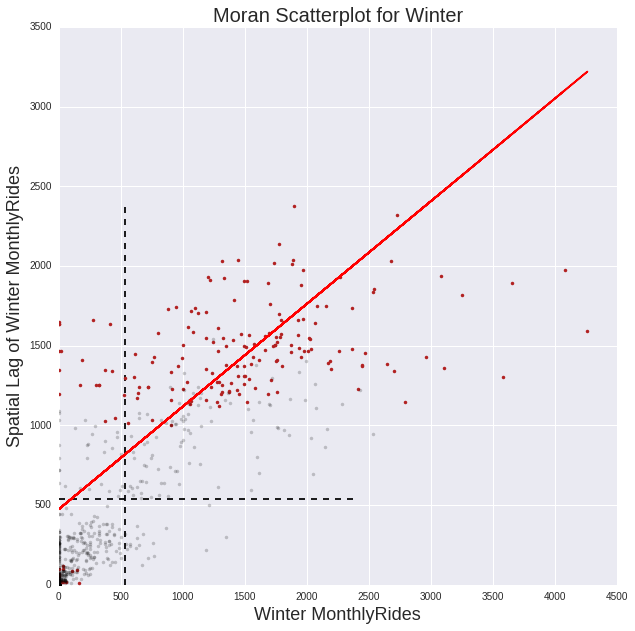

In [80]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot(sigs_w, W_sigs_w, '.', color='firebrick')
plt.plot(insigs_w, W_insigs_w, '.k', alpha=.2)
#plt.text(s='$I = %.3f$'% I_WinterMonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterMonthlyRide.mean(), WinterMonthlyRideLag.min(), WinterMonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterMonthlyRide.mean(), WinterMonthlyRideLag.min(), WinterMonthlyRideLag.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterMonthlyRide, a + b*WinterMonthlyRide, 'r')

plt.title('Moran Scatterplot for Winter', fontsize=20)
plt.ylabel('Spatial Lag of Winter MonthlyRides', fontsize=18)
plt.xlabel('Winter MonthlyRides', fontsize=18)

### Hot and Cold spots for winter

In [77]:
sig_w = LMo_WinterMonthlyRide.p_sim < 0.01
hotspots_w = LMo_WinterMonthlyRide.q==1 * sig_w
coldspots_w = LMo_WinterMonthlyRide.q==3 * sig_w
print "Number of Winter Hotspots:", hotspots_w.sum()
print "Number of Winter Coldspots:", coldspots_w.sum()

Number of Winter Hotspots: 197
Number of Winter Coldspots: 222


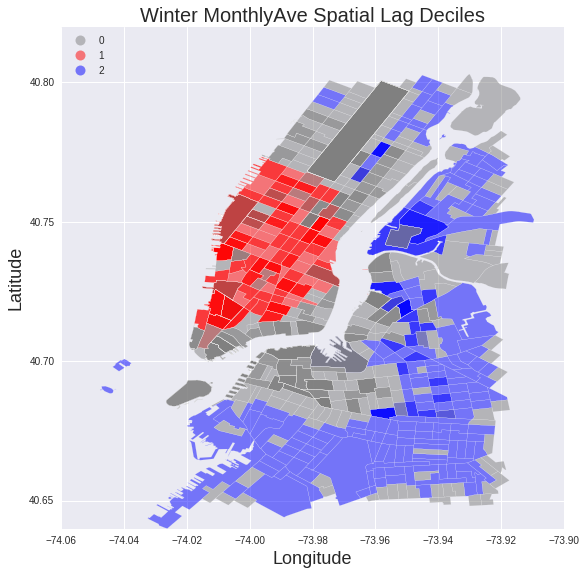

In [78]:
hcmap_w = colors.ListedColormap(['grey','red','blue'])
hotcold_w = hotspots_w*1 + coldspots_w*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterMonthlyAve_Zoom.assign(cl=hotcold_w).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_w, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
plt.title('Winter MonthlyAve Spatial Lag Deciles', fontsize=20)
plt.ylabel('Latitude', fontsize=18)
plt.xlabel('Longitude', fontsize=18)

#### Figure17: There are 195 ridership hotspots mostly located in lower Manhattan while the 218 coldspots are spread across middle Manhattan, Brooklyn and Queens

# Comparision of Summer and Winter trends

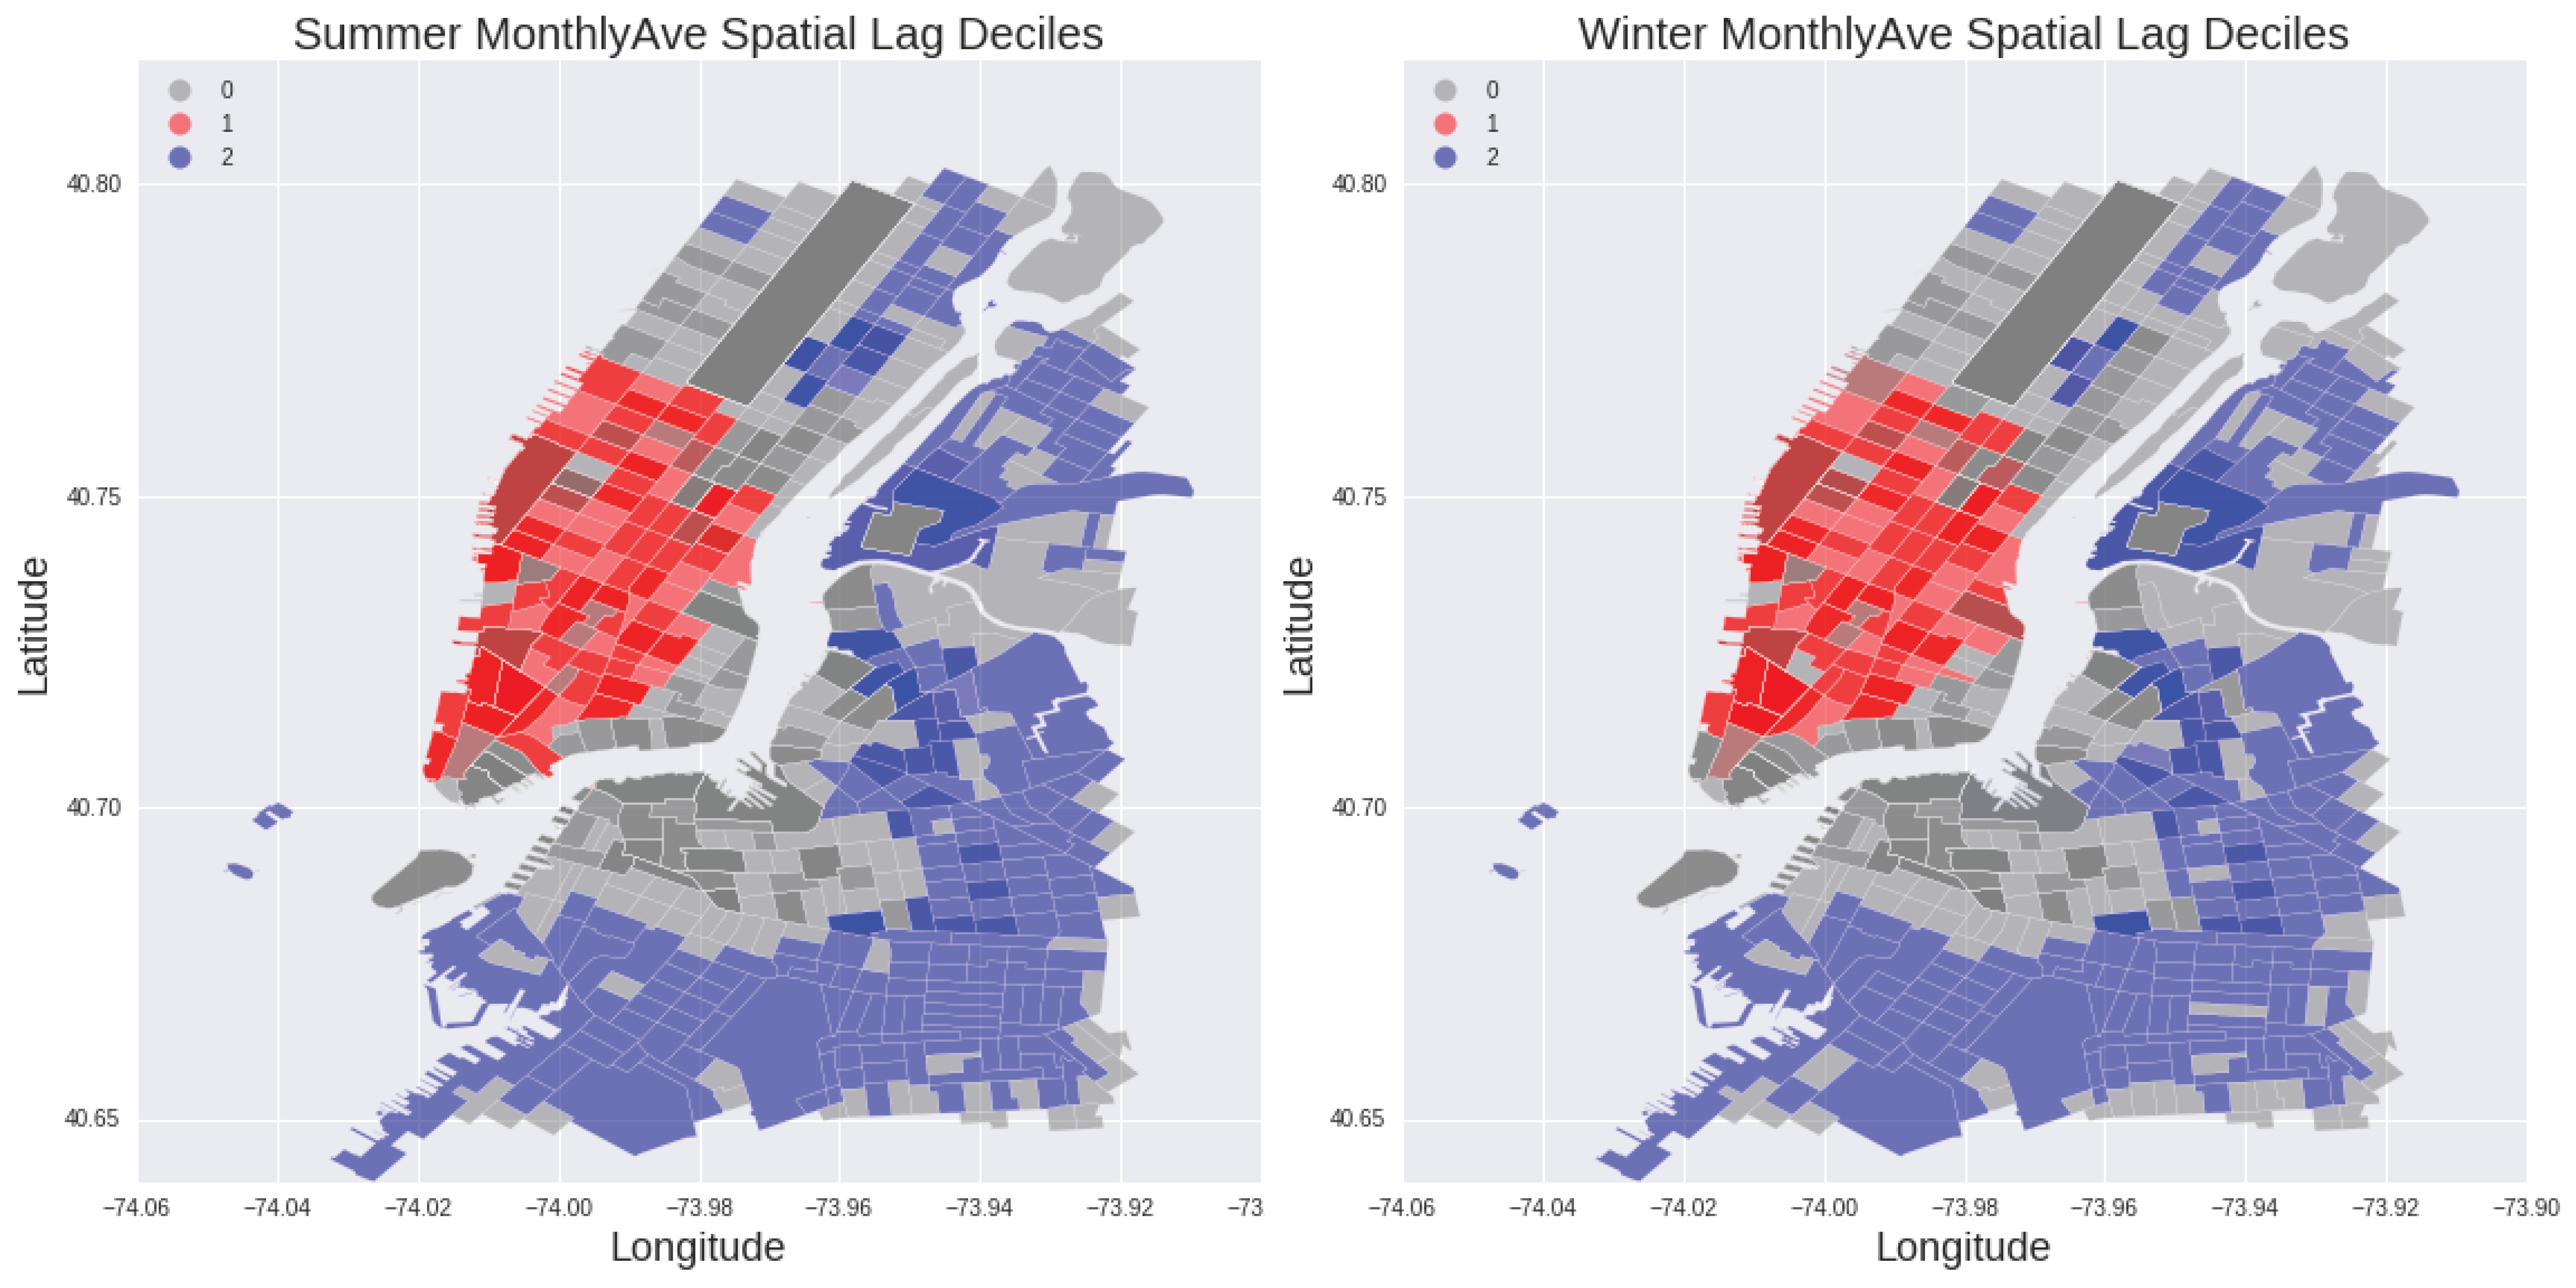

In [79]:
Image(filename = "hw10.jpg")

## Figure18: The spatial analysis of summer and winter ridership data of Citi Bike shows small difference in spatial distribution of hotspots and coldspots. There are slight more hotspots in winter (195) compared to summer (190). Meanwhile, the coldspots decline from summer (241) to winter (218). Based on this it can be inferred that though their is a fall in the absolute ridership numbers in the winter but the spatial spread of ridership is slightly (though not significantly) higher in winter. 